In [1]:
import zCurve as z
import csv
import cv2
import os
import numpy as np
import pandas as pd
import glob
import json 
import matplotlib.pyplot as plt

from ultralytics import YOLO

In [2]:
def calculateMortonFromList_with_zCurve(values):
    # Cap floating point numbers to one decimal place and convert to integers
    int_values = [int(round(value, 1) * 10) for value in values]
    value = z.interlace(*int_values, dims=len(int_values))
    return value 

In [3]:
seq_path = '../datasets/better_smirk/raw_data/left2right/two_cells/sq_00'
config_path = '../config.json'

In [4]:
with open(config_path, 'r') as _f:
    config = json.load(_f)

In [5]:
config['attention_grid']["grid_left_top_coord"]

[[120, 200], [180, 200], [240, 200], [340, 200], [400, 200], [460, 200]]

In [11]:
rgb_path = os.path.join(seq_path, 'cam000020.png')

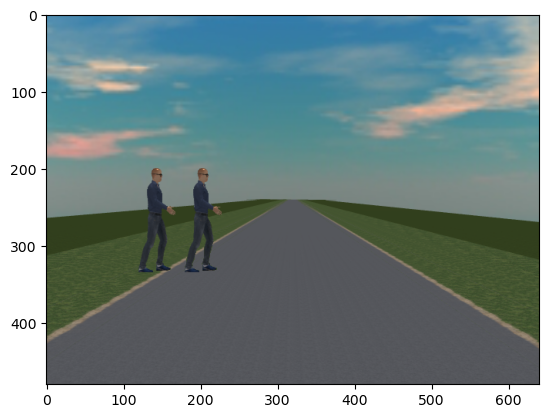

In [12]:
bgr = cv2.imread(rgb_path)
plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))

In [13]:
attention_cells_start_cord = np.array(config['attention_grid']['grid_left_top_coord'])
attention_cell_width = config['attention_grid']['width']
attention_cell_height = config['attention_grid']['height']

In [14]:
attention_cells_end_cord = [start_piont + np.array([attention_cell_width, attention_cell_height]) for start_piont in attention_cells_start_cord]

In [15]:
yolo = YOLO("yolo11x.pt")  # load an official model
# Predict with the model
#results = yolo([rgb_path, os.path.join(seq_path,'cam000202.png')])
results = yolo.predict(rgb_path, verbose=False)

In [16]:
yolo_start_point = []
yolo_end_point = []
for result in results:
    # result.show()
    result = result.boxes.cpu().numpy()
    if result.data.size > 0:
        xyxy = result.xyxy.astype(np.int64)
        xywh = result.xywh.astype(np.int64)
        for i in range(len(xyxy)):
            yolo_start_point.append([xyxy[i][0], xyxy[i][1]])
            yolo_end_point.append([xyxy[i][2], xyxy[i][3]])
    else:
        yolo_start_point = None
        yolo_end_point = None

    

In [17]:
print(yolo_start_point)
print(yolo_end_point)

[[119, 199], [179, 199]]
[[168, 335], [228, 335]]


In [18]:
def overlap(cell_cord, yolo_cord): # [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    x_left = max(cell_cord[0], yolo_cord[0])
    x_right = min(cell_cord[2], yolo_cord[2])
    y_top = max(cell_cord[1], yolo_cord[1])
    y_bottom = min(cell_cord[3], yolo_cord[3])

    if x_right < x_left or y_bottom < y_top:
        return 0, 0, 0, 0, 0
    overlap_area = (x_right - x_left) * (y_bottom - y_top)
    return overlap_area, x_left, y_top, x_right, y_bottom

In [19]:
if yolo_start_point is not None and yolo_end_point is not None:
    yolo_coord_all = np.concatenate([yolo_start_point, yolo_end_point], axis=1)
    print(yolo_coord_all)
else: 
    yolo_coord_all = [0,0,0,0]

[[119 199 168 335]
 [179 199 228 335]]


In [20]:
cell_coord_all = np.concatenate([attention_cells_start_cord, attention_cells_end_cord], axis=1)
cell_coord_all

array([[120, 200, 180, 320],
       [180, 200, 240, 320],
       [240, 200, 300, 320],
       [340, 200, 400, 320],
       [400, 200, 460, 320],
       [460, 200, 520, 320]])

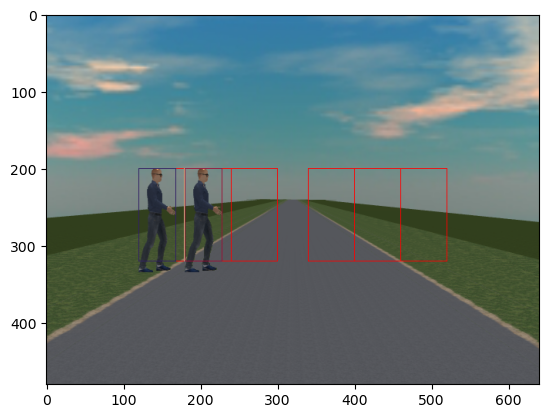

In [23]:
bgr_copy = bgr.copy()
for i in range(len(cell_coord_all)):
    cell_coord = cell_coord_all[i]
    cv2.rectangle(bgr_copy, cell_coord[:2], cell_coord[2:], (0,0,255), 1)
    overlap_cum = 0
    for j in yolo_coord_all:
        overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_coord, j)
        
        color = list(np.random.random(size=3) * 256)
        rgb_overlap = cv2.rectangle(bgr_copy, [x_left, y_top], [x_right, y_bottom], color, 1)
        
        overlap_cum += overlap_area
        #print(overlap_area, x_left, y_top, x_right, y_bottom)
    #print(overlap_cum)

    #break
plt.imshow(cv2.cvtColor(bgr_copy, cv2.COLOR_BGR2RGB))

In [31]:
input_zcurve = np.zeros(6)
for i in range(len(cell_coord_all)):
    cell_coord = cell_coord_all[i]
    overlap_cum = 0
    for j in yolo_coord_all:
        overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_coord, j)    
        overlap_cum += overlap_area

    cell_area = config['attention_grid']['width'] * config['attention_grid']['height']
    if overlap_cum > 0:
        input_zcurve[i] = overlap_cum / cell_area
    
    print(overlap_cum, cell_area, x_left, y_top, x_right, y_bottom)
print(input_zcurve * 10)

5880 7200 179 200 180 320
5760 7200 180 200 228 320
0 7200 0 0 0 0
0 7200 0 0 0 0
0 7200 0 0 0 0
0 7200 0 0 0 0
[     8.1667           8           0           0           0           0]


In [33]:
morton = calculateMortonFromList_with_zCurve(input_zcurve * 10)
morton

206208761920

### Combine everything to process all images in a sequence. 

In [35]:
morton_codes = []
for anno_frame in sorted(glob.glob(os.path.join(seq_path, '*.labels.png'))):
    rgb_frame = anno_frame.replace('.labels.png', '.png')
    yolo_start_point = []
    yolo_end_point = []
    yolo = YOLO("yolo11x.pt") 
    results = yolo.predict(rgb_frame, verbose=False)
    for result in results:
        result = result.boxes.cpu().numpy()
        if result.data.size > 0:
            xyxy = result.xyxy.astype(np.int64)
            xywh = result.xywh.astype(np.int64)
            for i in range(len(xyxy)):
                yolo_start_point.append([xyxy[i][0], xyxy[i][1]])
                yolo_end_point.append([xyxy[i][2], xyxy[i][3]])
        else:
            yolo_start_point = None
            yolo_end_point = None

    if yolo_start_point is not None and yolo_end_point is not None:
        yolo_coord_all = np.concatenate([yolo_start_point, yolo_end_point], axis=1)
    else: 
        yolo_coord_all = [0,0,0,0]
        
    cell_coord_all = np.concatenate([attention_cells_start_cord, attention_cells_end_cord], axis=1)

    bgr = cv2.imread(rgb_frame)

    input_zcurve = np.zeros(6)
    for i in range(len(cell_coord_all)):
        cell_coord = cell_coord_all[i]
        overlap_cum = 0
        for j in yolo_coord_all:
            overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_coord, j)
            color = list(np.random.random(size=3) * 256)
            bgr_overlap = cv2.rectangle(bgr, [x_left, y_top], [x_right, y_bottom], color, 1)
            overlap_cum += overlap_area
        
        cell_area = config['attention_grid']['width'] * config['attention_grid']['height']
        if overlap_cum > 0:
            input_zcurve[i] = overlap_cum / cell_area
    
    # overlap_path = rgb_frame.replace('datasets/better_smirk', 'outputs/yolo_better_smirk')
    # if not os.path.exists(os.path.dirname(overlap_path)):
    #     os.makedirs(os.path.dirname(overlap_path))
    # cv2.imwrite(overlap_path, bgr_overlap)

    morton_bgr = calculateMortonFromList_with_zCurve(input_zcurve)
    morton_codes.append({'frame': rgb_frame, 'morton': morton_bgr})

morton_codes = pd.DataFrame(morton_codes, columns=['frame', 'morton'])
morton_codes.to_csv('../outputs/yolo_morton_better_smirk.csv', sep=';', index=False)

### Read the saved csv and plot

In [36]:
morton_codes_yolo_proportion = pd.read_csv('../outputs/yolo_morton_better_smirk.csv', sep=';')
morton_codes_yolo_proportion = morton_codes_yolo_proportion.to_numpy()

In [41]:
mortons_seq = []
for i in range(len(morton_codes_yolo_proportion)):
    frame, morton = morton_codes_yolo_proportion[i]
    mortons_seq.append(int(morton) / 10000)
print(mortons_seq)

[0.4097, 0.416, 26.2144, 26.2144, 0.4161, 0.4161, 0.416, 26.2144, 26.2336, 26.2338, 27.04, 26.2275, 26.2274, 27.0336, 27.0336, 27.0528, 27.053, 78.6496, 1.2481, 1.248, 78.6432, 78.6432, 78.6565, 78.6816, 78.6438, 52.8707, 52.8704, 52.8647, 54.4901, 54.5152, 54.5152, 2.4771, 2.477, 2.4774, 157.2865, 157.3248, 157.3122, 157.3122, 157.2864, 105.6898, 105.6898, 105.6896, 105.6774, 105.7026, 2.4836, 1.6774, 1.6774, 104.8704, 104.9472, 104.9346, 104.9352, 104.9088, 1.7156, 1.7156, 4.9412, 4.9924, 4.9928, 4.9928, 4.9668, 4.9664, 209.7412, 209.7412, 209.7432, 209.8944, 209.7156, 209.7168, 3.3304, 209.8192, 216.2712, 216.3216, 216.372, 216.2704, 216.2704, 216.3712, 629.1456, 629.2992, 629.2992, 629.252, 9.9864, 9.9864, 422.7624, 422.9632, 435.968, 435.9208, 435.8144, 435.8176, 432.5928, 432.7952, 1258.3944, 1258.3976, 1258.5984, 845.5184, 19.968, 19.968, 845.5184, 845.7232, 845.7216, 845.6208, 845.416, 845.4144]


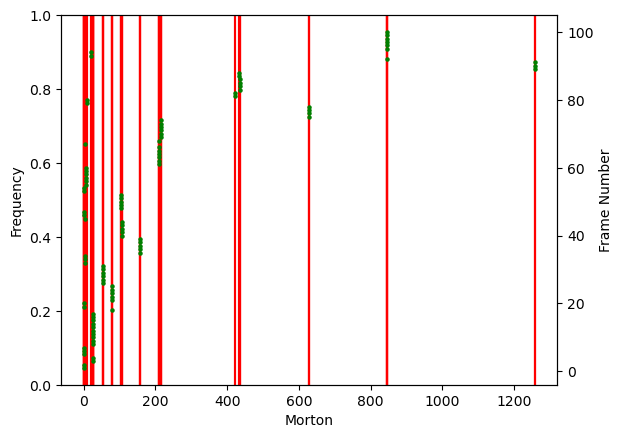

In [42]:
fig, ax1 = plt.subplots()
ax1.set_xlabel("Morton")
ax1.set_ylabel("Frequency")
ax1.set_ylim((0, 1))
ax1.eventplot(mortons_seq, orientation='horizontal', colors="red",lineoffsets=0.5)

ax2 = ax1.twinx()
for frame_id in range(len(mortons_seq)):
    x=mortons_seq[frame_id]
    y=frame_id+1
    ax2.scatter(x, y, s=5, color='green')
    ax2.set_ylabel("Frame Number")

#fig.savefig('asas.png')